In [9]:
# Imports
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

torch.cuda.empty_cache()

In [10]:
model = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model_regularized_l1 = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../models/vess_map_regularized_l1_200.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../models/vess_map_regularized_l2_200.pth"))

<All keys matched successfully>

In [11]:
def get_model_weights(model):
    weights = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):  
            weights.append(module.weight.detach().cpu().numpy())  
    return weights

In [12]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        # Flatten the parameter tensors and count zeros
        flattened_params = param.view(-1)
        # TODO: instead of zero, get less than a threshold really small 10⁻8
        zero_params += torch.sum(flattened_params == 0).item()
        total_params += flattened_params.size(0)

    sparsity = zero_params / total_params
    return sparsity

In [13]:
threshold = 1e-3  
sparsity_threshold = 1e-4 


def analyze_weights(weights, threshold, model):
    # Flatten each weight matrix and perform the comparison
    above_threshold = sum(np.count_nonzero(np.abs(weight.flatten()) > threshold) for weight in weights)
    below_threshold = sum(np.count_nonzero(np.abs(weight.flatten()) <= threshold) for weight in weights)
    sparsity = calculate_sparsity(model)  # Adjust the threshold for sparsity as needed
    
    return above_threshold, below_threshold, sparsity



weights_model = get_model_weights(model)
weights_model_l1 = get_model_weights(model_regularized_l1)
weights_model_l2 = get_model_weights(model_regularized_l2)

analysis_model = analyze_weights(weights_model, threshold, model)
analysis_model_l1 = analyze_weights(weights_model_l1, threshold, model_regularized_l1)
analysis_model_l2 = analyze_weights(weights_model_l2, threshold, model_regularized_l2)

<Figure size 400x300 with 0 Axes>

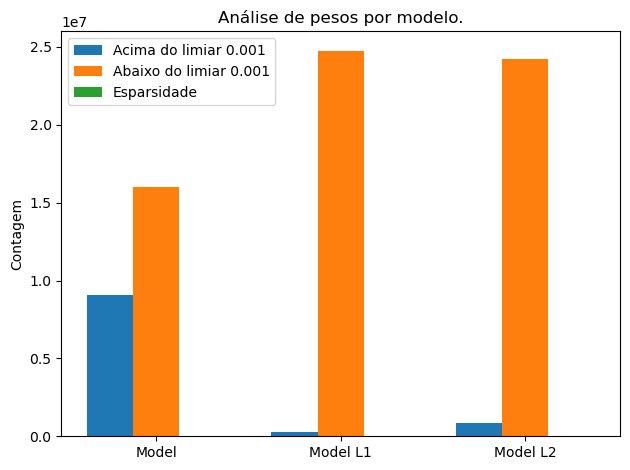

In [14]:
labels = ['Model', 'Model L1', 'Model L2']
above_threshold_values = [analysis_model[0], analysis_model_l1[0], analysis_model_l2[0]]
below_threshold_values = [analysis_model[1], analysis_model_l1[1], analysis_model_l2[1]]
sparsity_values = [analysis_model[2], analysis_model_l1[2], analysis_model_l2[2]]


x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

plt.figure(figsize=(4, 3))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, above_threshold_values, width, label=f'Acima do limiar {threshold}')
rects2 = ax.bar(x, below_threshold_values, width, label=f'Abaixo do limiar {threshold}')
rects3 = ax.bar(x + width, sparsity_values, width, label='Esparsidade')


# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Contagem')
ax.set_title('Análise de pesos por modelo.')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig('/home/fonta42/Desktop/imagens-ic-relatorio-final/weight_sparsity_analysis.pdf', format='pdf')

plt.show()

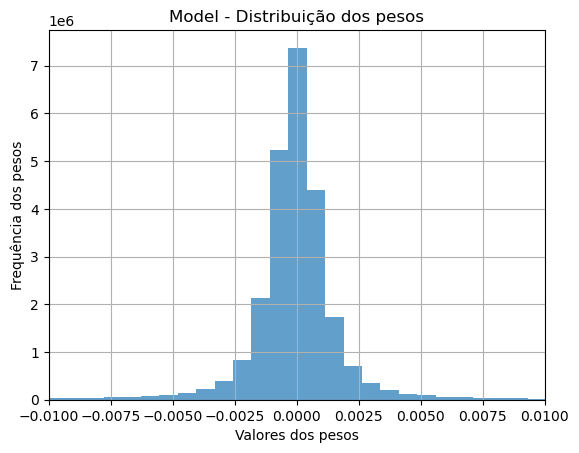

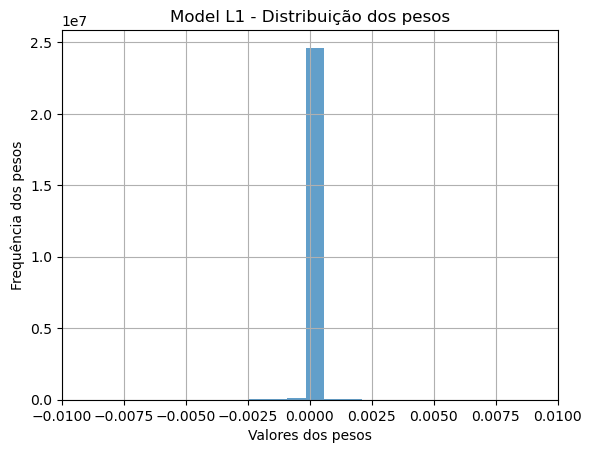

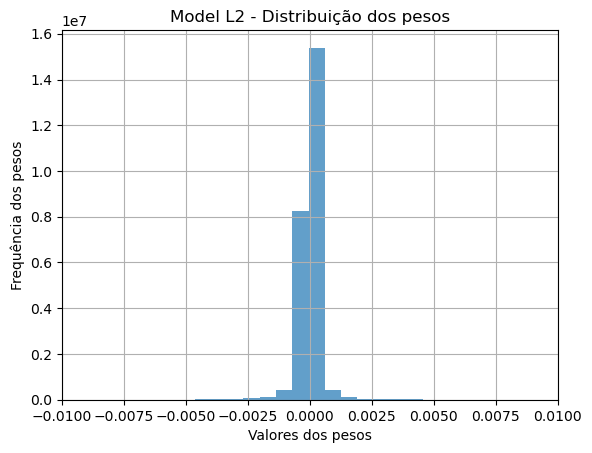

In [15]:
import matplotlib.pyplot as plt

def plot_weight_histogram(weights, title):
    # Flatten all weight arrays and combine them into one list
    all_weights = np.hstack([w.flatten() for w in weights])

    plt.hist(all_weights, bins=1000, alpha=0.7)
    plt.xlim((-0.01, 0.01))
    plt.title(title)
    plt.xlabel('Valores dos pesos')
    plt.ylabel('Frequência dos pesos')
    plt.grid(True)
    plt.show()

plot_weight_histogram(weights_model, "Model - Distribuição dos pesos")
plot_weight_histogram(weights_model_l1, "Model L1 - Distribuição dos pesos")
plot_weight_histogram(weights_model_l2, "Model L2 - Distribuição dos pesos")

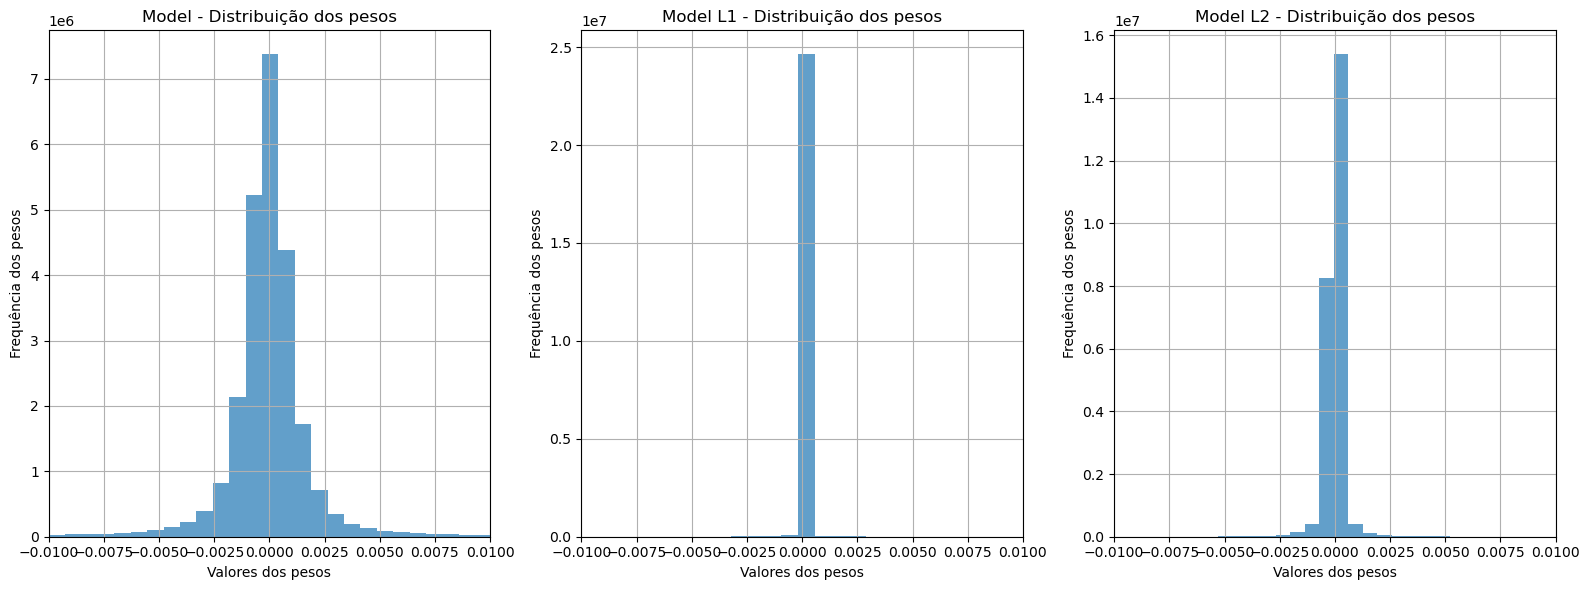

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weight_histograms(weight_sets, titles):
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))

    for i, weights in enumerate(weight_sets):
        # Flatten all weight arrays and combine them into one list for each set
        all_weights = np.hstack([w.flatten() for w in weights])

        # Plot histogram on each subplot
        axes[i].hist(all_weights, bins=1000, alpha=0.7)
        axes[i].set_xlim((-0.01, 0.01))
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Valores dos pesos')
        axes[i].set_ylabel('Frequência dos pesos')
        axes[i].grid(True)
        

    plt.tight_layout()
    plt.savefig('/home/fonta42/Desktop/imagens-ic-relatorio-final/model_analysis_all_models.pdf', format='pdf')

    plt.show()

# Example of how to call the function
weight_sets = [weights_model, weights_model_l1, weights_model_l2]
titles = ["Model - Distribuição dos pesos", "Model L1 - Distribuição dos pesos", "Model L2 - Distribuição dos pesos"]
plot_weight_histograms(weight_sets, titles)
